# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [3]:
depth = [16, 32, 64]
fc = [1024, 128, 1]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #公共网络部件
        self.net_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1d = nn.BatchNorm1d(num_features=fc[1])
        
        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(in_channels=1, out_channels=depth[0], kernel_size=5, padding = 2)
        self.net1_conv2 = nn.Conv2d(in_channels=depth[0], out_channels=depth[1], kernel_size=5, padding = 2) 
        self.net1_conv3 = nn.Conv2d(in_channels=depth[1], out_channels=depth[2], kernel_size=5, padding = 2) 
         
        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(in_channels=1, out_channels=depth[0], kernel_size=5, padding = 2)
        self.net2_conv2 = nn.Conv2d(in_channels=depth[0], out_channels=depth[1], kernel_size=5, padding = 2)
        self.net2_conv3 = nn.Conv2d(in_channels=depth[1], out_channels=depth[2], kernel_size=5, padding = 2) 
         
        #后面的全连阶层
        self.fc1 = nn.Linear(in_features=2 * (image_size // 4 // 2) * (image_size // 4 // 2) * depth[2] , 
                             out_features=fc[0])
        self.fc2 = nn.Linear(in_features=fc[0], out_features=fc[1])
        self.fc3 = nn.Linear(in_features=fc[1], out_features=fc[2])
 
    def forward(self, x, y, training = True):
        #第一张图像的处理流程
        x = F.leaky_relu(self.net1_conv1(x)) # 1*28*28 -> 16*28*28
        x = self.net_pool(x) # 16*28*28 -> 16*14*14
        x = F.leaky_relu(self.net1_conv2(x)) # 16*14*14 -> 32*14*14
        x = self.net_pool(x) # 32*14*14 -> 32*7*7
        x = F.leaky_relu(self.net1_conv3(x)) # 32*7*7 -> 64*7*7
        x = self.net_pool(x) # 64*7*7 -> 64*3*3
        x = x.view(-1, (image_size // 4 // 2) * (image_size // 4 // 2) * depth[2]) # flatten
         
        #第二张图像的处理流程
        y = F.leaky_relu(self.net2_conv1(y)) # size change like above
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv3(y))
        y = self.net_pool(y)
        y = y.view(-1, (image_size // 4 // 2) * (image_size // 4 // 2) * depth[2])
         
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1) # concatenate in columns
        z = F.leaky_relu(self.fc1(z))
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = F.leaky_relu(self.fc2(z))
        z = self.bn1d(z) #批量正则化
        z = F.leaky_relu(self.fc3(z))
        
        return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y.view(-1)).type(torch.LongTensor)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)


In [4]:
#将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #
optimizer = optim.Adam(net.parameters()) #SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
results = {}

In [5]:
%%time

stranges = []

#开始训练循环，本部分代码需要补齐
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        optimizer.zero_grad()
        net.train()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
#         if 0==idx:
#             break
        loss = criterion(outputs.type(torch.FloatTensor), Variable(labels.type(torch.FloatTensor)))
        loss.backward()
        optimizer.step()
        # update losses
        losses.append(loss.data.numpy())
        
        if idx % 100 == 0:
            net.eval()
            val_losses = []
            val_right_all = []
#             size_right, size_all = [], []
            for jdx, data_val in enumerate(zip(val_loader1, val_loader2)):
                ((xx1, yy1), (xx2, yy2)) = data_val
                v_outputs = net(Variable(xx1), Variable(xx2)) 
                v_labels = yy1 + yy2
                v_loss = criterion(v_outputs.type(torch.FloatTensor), Variable(v_labels.type(torch.FloatTensor)))
                # add val_loss, val_rights
                val_losses.append(v_loss.data.numpy())
                val_right_all.append(rightness(v_outputs.data, v_labels))
#                 aa,bb = rightness(v_outputs.data, v_labels)
#                 if aa > bb:
#                     stranges.append((data_val, v_outputs, aa, bb))
#                     break
#                 print(v_outputs.data.shape, v_labels.shape, rightness(v_outputs.data, v_labels))
                
            right_ratio = np.sum([rr for rr,aa in val_right_all]) / float(np.sum([aa for rr,aa in val_right_all]))
            #每间隔一定周期就打印一下训练集、校验集的准确率结果
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])


第0周期，第(0/938)个撮，训练误差：90.37, 校验误差：96.55, 准确率：0.01
第0周期，第(100/938)个撮，训练误差：51.27, 校验误差：16.53, 准确率：0.09
第0周期，第(200/938)个撮，训练误差：33.25, 校验误差：16.50, 准确率：0.05
第0周期，第(300/938)个撮，训练误差：25.66, 校验误差：13.50, 准确率：0.07
第0周期，第(400/938)个撮，训练误差：21.16, 校验误差：4.32, 准确率：0.21
第0周期，第(500/938)个撮，训练误差：18.01, 校验误差：3.14, 准确率：0.25
第0周期，第(600/938)个撮，训练误差：15.63, 校验误差：3.01, 准确率：0.27
第0周期，第(700/938)个撮，训练误差：13.85, 校验误差：2.79, 准确率：0.27
第0周期，第(800/938)个撮，训练误差：12.48, 校验误差：2.57, 准确率：0.26
第0周期，第(900/938)个撮，训练误差：11.41, 校验误差：2.21, 准确率：0.33
第1周期，第(0/938)个撮，训练误差：1.87, 校验误差：2.37, 准确率：0.33
第1周期，第(100/938)个撮，训练误差：2.42, 校验误差：2.08, 准确率：0.35
第1周期，第(200/938)个撮，训练误差：2.37, 校验误差：1.84, 准确率：0.37
第1周期，第(300/938)个撮，训练误差：2.22, 校验误差：1.78, 准确率：0.40
第1周期，第(400/938)个撮，训练误差：2.17, 校验误差：1.78, 准确率：0.38
第1周期，第(500/938)个撮，训练误差：2.13, 校验误差：1.61, 准确率：0.40
第1周期，第(600/938)个撮，训练误差：2.06, 校验误差：1.69, 准确率：0.36
第1周期，第(700/938)个撮，训练误差：2.02, 校验误差：1.52, 准确率：0.42
第1周期，第(800/938)个撮，训练误差：1.96, 校验误差：1.38, 准确率：0.43
第1周期，第(900/938)个撮，训练误差：1.93, 校验误差：1.54, 准确率：0.41
第2周期，第(0/9

第16周期，第(700/938)个撮，训练误差：0.40, 校验误差：0.34, 准确率：0.92
第16周期，第(800/938)个撮，训练误差：0.41, 校验误差：0.40, 准确率：0.93
第16周期，第(900/938)个撮，训练误差：0.41, 校验误差：0.40, 准确率：0.92
第17周期，第(0/938)个撮，训练误差：0.36, 校验误差：0.42, 准确率：0.90
第17周期，第(100/938)个撮，训练误差：0.34, 校验误差：0.39, 准确率：0.92
第17周期，第(200/938)个撮，训练误差：0.40, 校验误差：0.38, 准确率：0.92
第17周期，第(300/938)个撮，训练误差：0.40, 校验误差：0.33, 准确率：0.93
第17周期，第(400/938)个撮，训练误差：0.38, 校验误差：0.34, 准确率：0.93
第17周期，第(500/938)个撮，训练误差：0.38, 校验误差：0.38, 准确率：0.92
第17周期，第(600/938)个撮，训练误差：0.38, 校验误差：0.39, 准确率：0.93
第17周期，第(700/938)个撮，训练误差：0.39, 校验误差：0.36, 准确率：0.93
第17周期，第(800/938)个撮，训练误差：0.38, 校验误差：0.35, 准确率：0.92
第17周期，第(900/938)个撮，训练误差：0.38, 校验误差：0.35, 准确率：0.93
第18周期，第(0/938)个撮，训练误差：0.13, 校验误差：0.37, 准确率：0.93
第18周期，第(100/938)个撮，训练误差：0.36, 校验误差：0.37, 准确率：0.93
第18周期，第(200/938)个撮，训练误差：0.37, 校验误差：0.31, 准确率：0.93
第18周期，第(300/938)个撮，训练误差：0.36, 校验误差：0.36, 准确率：0.93
第18周期，第(400/938)个撮，训练误差：0.36, 校验误差：0.40, 准确率：0.87
第18周期，第(500/938)个撮，训练误差：0.37, 校验误差：0.41, 准确率：0.93
第18周期，第(600/938)个撮，训练误差：0.36, 校验误差：0.36, 准确率：0.94
第18周

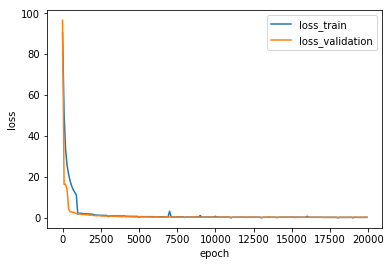

In [6]:
record_loss_train = [xx[0] for xx in records]
record_loss_val = [xx[1] for xx in records]
record_acc_val = [xx[2] for xx in records]

plt.plot(np.arange(len(records))*100, record_loss_train, label='loss_train')
plt.plot(np.arange(len(records))*100, record_loss_val, label='loss_validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

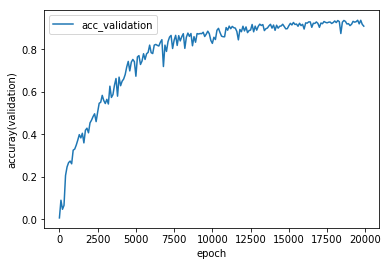

In [7]:
plt.plot(np.arange(len(records))*100, record_acc_val, label='acc_validation')
plt.xlabel('epoch')
plt.ylabel('accuray(validation)')
plt.legend()
plt.show()

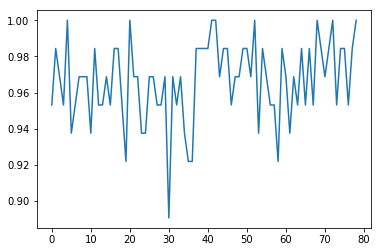

In [8]:
# 在测试集上运行我们的加法机网络，并测试预测准确度

net.eval()

eval_rights = []
for kdx, data_test in enumerate(zip(test_loader1, test_loader2)):
    ((xt1, yt1), (xt2, yt2)) = data_test
    xt1, xt2 = Variable(xt1), Variable(xt2)
    labelt = Variable(yt1+yt2)
    output_t = net(xt1, xt2)
    loss = criterion(output_t.type(torch.FloatTensor), labelt.type(torch.FloatTensor))
    rr,aa=rightness(output_t.data, labelt.data)
    eval_rights.append(rr/float(aa))
    
plt.plot(np.arange(len(eval_rights)), eval_rights)
plt.show()